In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
num_epochs = 30
batch_size = 32
learning_rate = 0.001

In [16]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'Test': transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [17]:
data_dir = r'C:\Users\ND01VY\OneDrive - Aalborg Universitet\Desktop\thermal images UL - Split-Train-Tes'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

print(class_names)

['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [18]:
inputs, classes = next(iter(dataloaders['Train']))

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_plt = []  
    accuracy_plt = []
    test_loss_plt = []  
    test_accuracy_plt = []
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, classes in dataloaders[phase]:
                inputs = inputs.to(device)
                classes = classes.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)

            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
             
            if phase == 'Train':
                accuracy_plt.append(epoch_acc)
                loss_plt.append(epoch_loss)
                
            if phase == 'Test':
                test_accuracy_plt.append(epoch_acc)
                test_loss_plt.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))
    
    plt.plot(accuracy_plt,label='Training Accuracy')  
    plt.plot(test_accuracy_plt,label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, 29))
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(loss_plt,label='Training Loss')  
    plt.plot(test_loss_plt,label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, 29))
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Loaded pretrained weights for efficientnet-b4
Epoch 0/29
----------
Train Loss: 1.2818 Acc: 0.5374
Test Loss: 1.6070 Acc: 0.4766

Epoch 1/29
----------
Train Loss: 0.6736 Acc: 0.7933
Test Loss: 1.6036 Acc: 0.4219

Epoch 2/29
----------
Train Loss: 0.4705 Acc: 0.8839
Test Loss: 1.8558 Acc: 0.4297

Epoch 3/29
----------
Train Loss: 0.3509 Acc: 0.9213
Test Loss: 1.9225 Acc: 0.4609

Epoch 4/29
----------
Train Loss: 0.2928 Acc: 0.9232
Test Loss: 1.6893 Acc: 0.4766

Epoch 5/29
----------
Train Loss: 0.2471 Acc: 0.9291
Test Loss: 1.5636 Acc: 0.5156

Epoch 6/29
----------
Train Loss: 0.2009 Acc: 0.9429
Test Loss: 1.6064 Acc: 0.5469

Epoch 7/29
----------
Train Loss: 0.1804 Acc: 0.9469
Test Loss: 1.4260 Acc: 0.5859

Epoch 8/29
----------
Train Loss: 0.2004 Acc: 0.9429
Test Loss: 1.2504 Acc: 0.6172

Epoch 9/29
----------
Train Loss: 0.1477 Acc: 0.9646
Test Loss: 1.1205 Acc: 0.6562

Epoch 10/29
----------
Train Loss: 0.1545 Acc: 0.9528
Test Loss: 1.0170 Acc: 0.6484

Epoch 11/29
----------
Train 

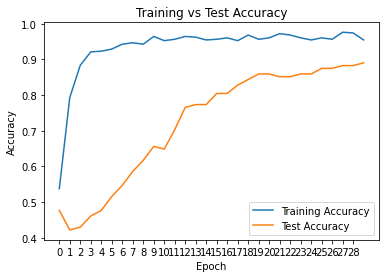

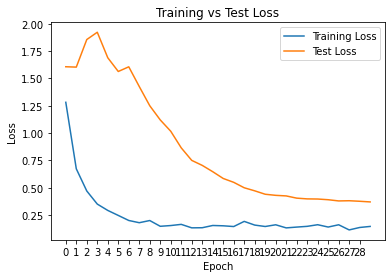

In [20]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

for param in model.parameters():
    param.requires_grad = False
in_features = model._fc.in_features

model._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.25),
    nn.Linear(128, 6),
    )


model = model.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model._fc.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model._fc.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=num_epochs)


In [21]:
inputs, labels = next(iter(dataloaders['Test']))

<AxesSubplot:>

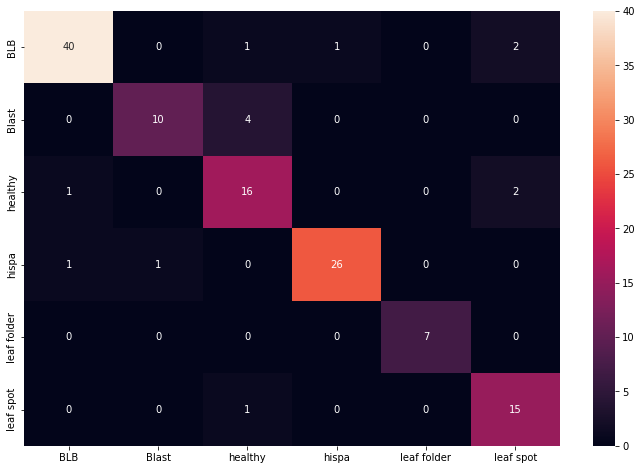

In [22]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['Test']:
        output = model(inputs) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


classes = ('BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_true, target_names=classes))

              precision    recall  f1-score   support

         BLB       0.91      0.95      0.93        42
       Blast       0.71      0.91      0.80        11
     healthy       0.84      0.73      0.78        22
       hispa       0.93      0.96      0.95        27
 leaf folder       1.00      1.00      1.00         7
   leaf spot       0.94      0.79      0.86        19

    accuracy                           0.89       128
   macro avg       0.89      0.89      0.89       128
weighted avg       0.89      0.89      0.89       128



In [24]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3,4,5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l, np.array(y_pred)==l, pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.976190,0.909091
1,1,0.991228,0.714286
2,2,0.944954,0.842105
3,3,0.990000,0.928571
4,4,1.000000,1.000000
5,5,0.964286,0.937500
